### This notebook analyze the data for all the sensers and I look at the frequency of failure for individual sensors and try to find the edge cases. Analyzing the edge case, I aim to see what could be the potential reason failure of sensors.

FYI: 

The sensor data is extracted for past 30 days.  
We are only considering a sensor failed if we do not have data for more than 1 hour in the database 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
import os

folder_path = '100_days_data/'  # Replace with the actual folder path

# Get a list of all files in the folder
files = os.listdir(folder_path)

sensors = []
i = 0

dataframes = {}


for file in files:
    if file == '.DS_Store':
        pass

        name = file.replace('.csv', '')
        sensors.append(name)

        # adding data from csv file to the list of data which is placed in dataframe which is a list
        dataframes[name] = pd.read_csv('100_days_data/' + file)
%store dataframes

Stored 'dataframes' (dict)


In [3]:
print(f" We have data for {len(sensors)} sensors.")

 We have data for 53 sensors.


In [4]:
failing_detail = {} 
missing = {}
    
for i in range(len(sensors)):
    df = dataframes[sensors[i]]
    # Convert the 'time' column to datetime format (if it's not already)
    df['time'] = pd.to_datetime(df['time'])

    # Sort the DataFrame by the 'time' column
    df.sort_values('time', inplace=True)

    # Calculate the time difference between consecutive rows
    time_diff = df['time'].diff()

    # Find the indexes where the time difference is greater than one hour (3600 seconds)
    missing_indexes = time_diff[time_diff > pd.Timedelta(hours=1)].index

    missing[sensors[i]] = missing_indexes

    num = len(missing_indexes)
    
    # maintaining recored of failure for analysis
    failing_detail[sensors[i]] = num   
   

Text(0.5, 0, 'No. of failures')

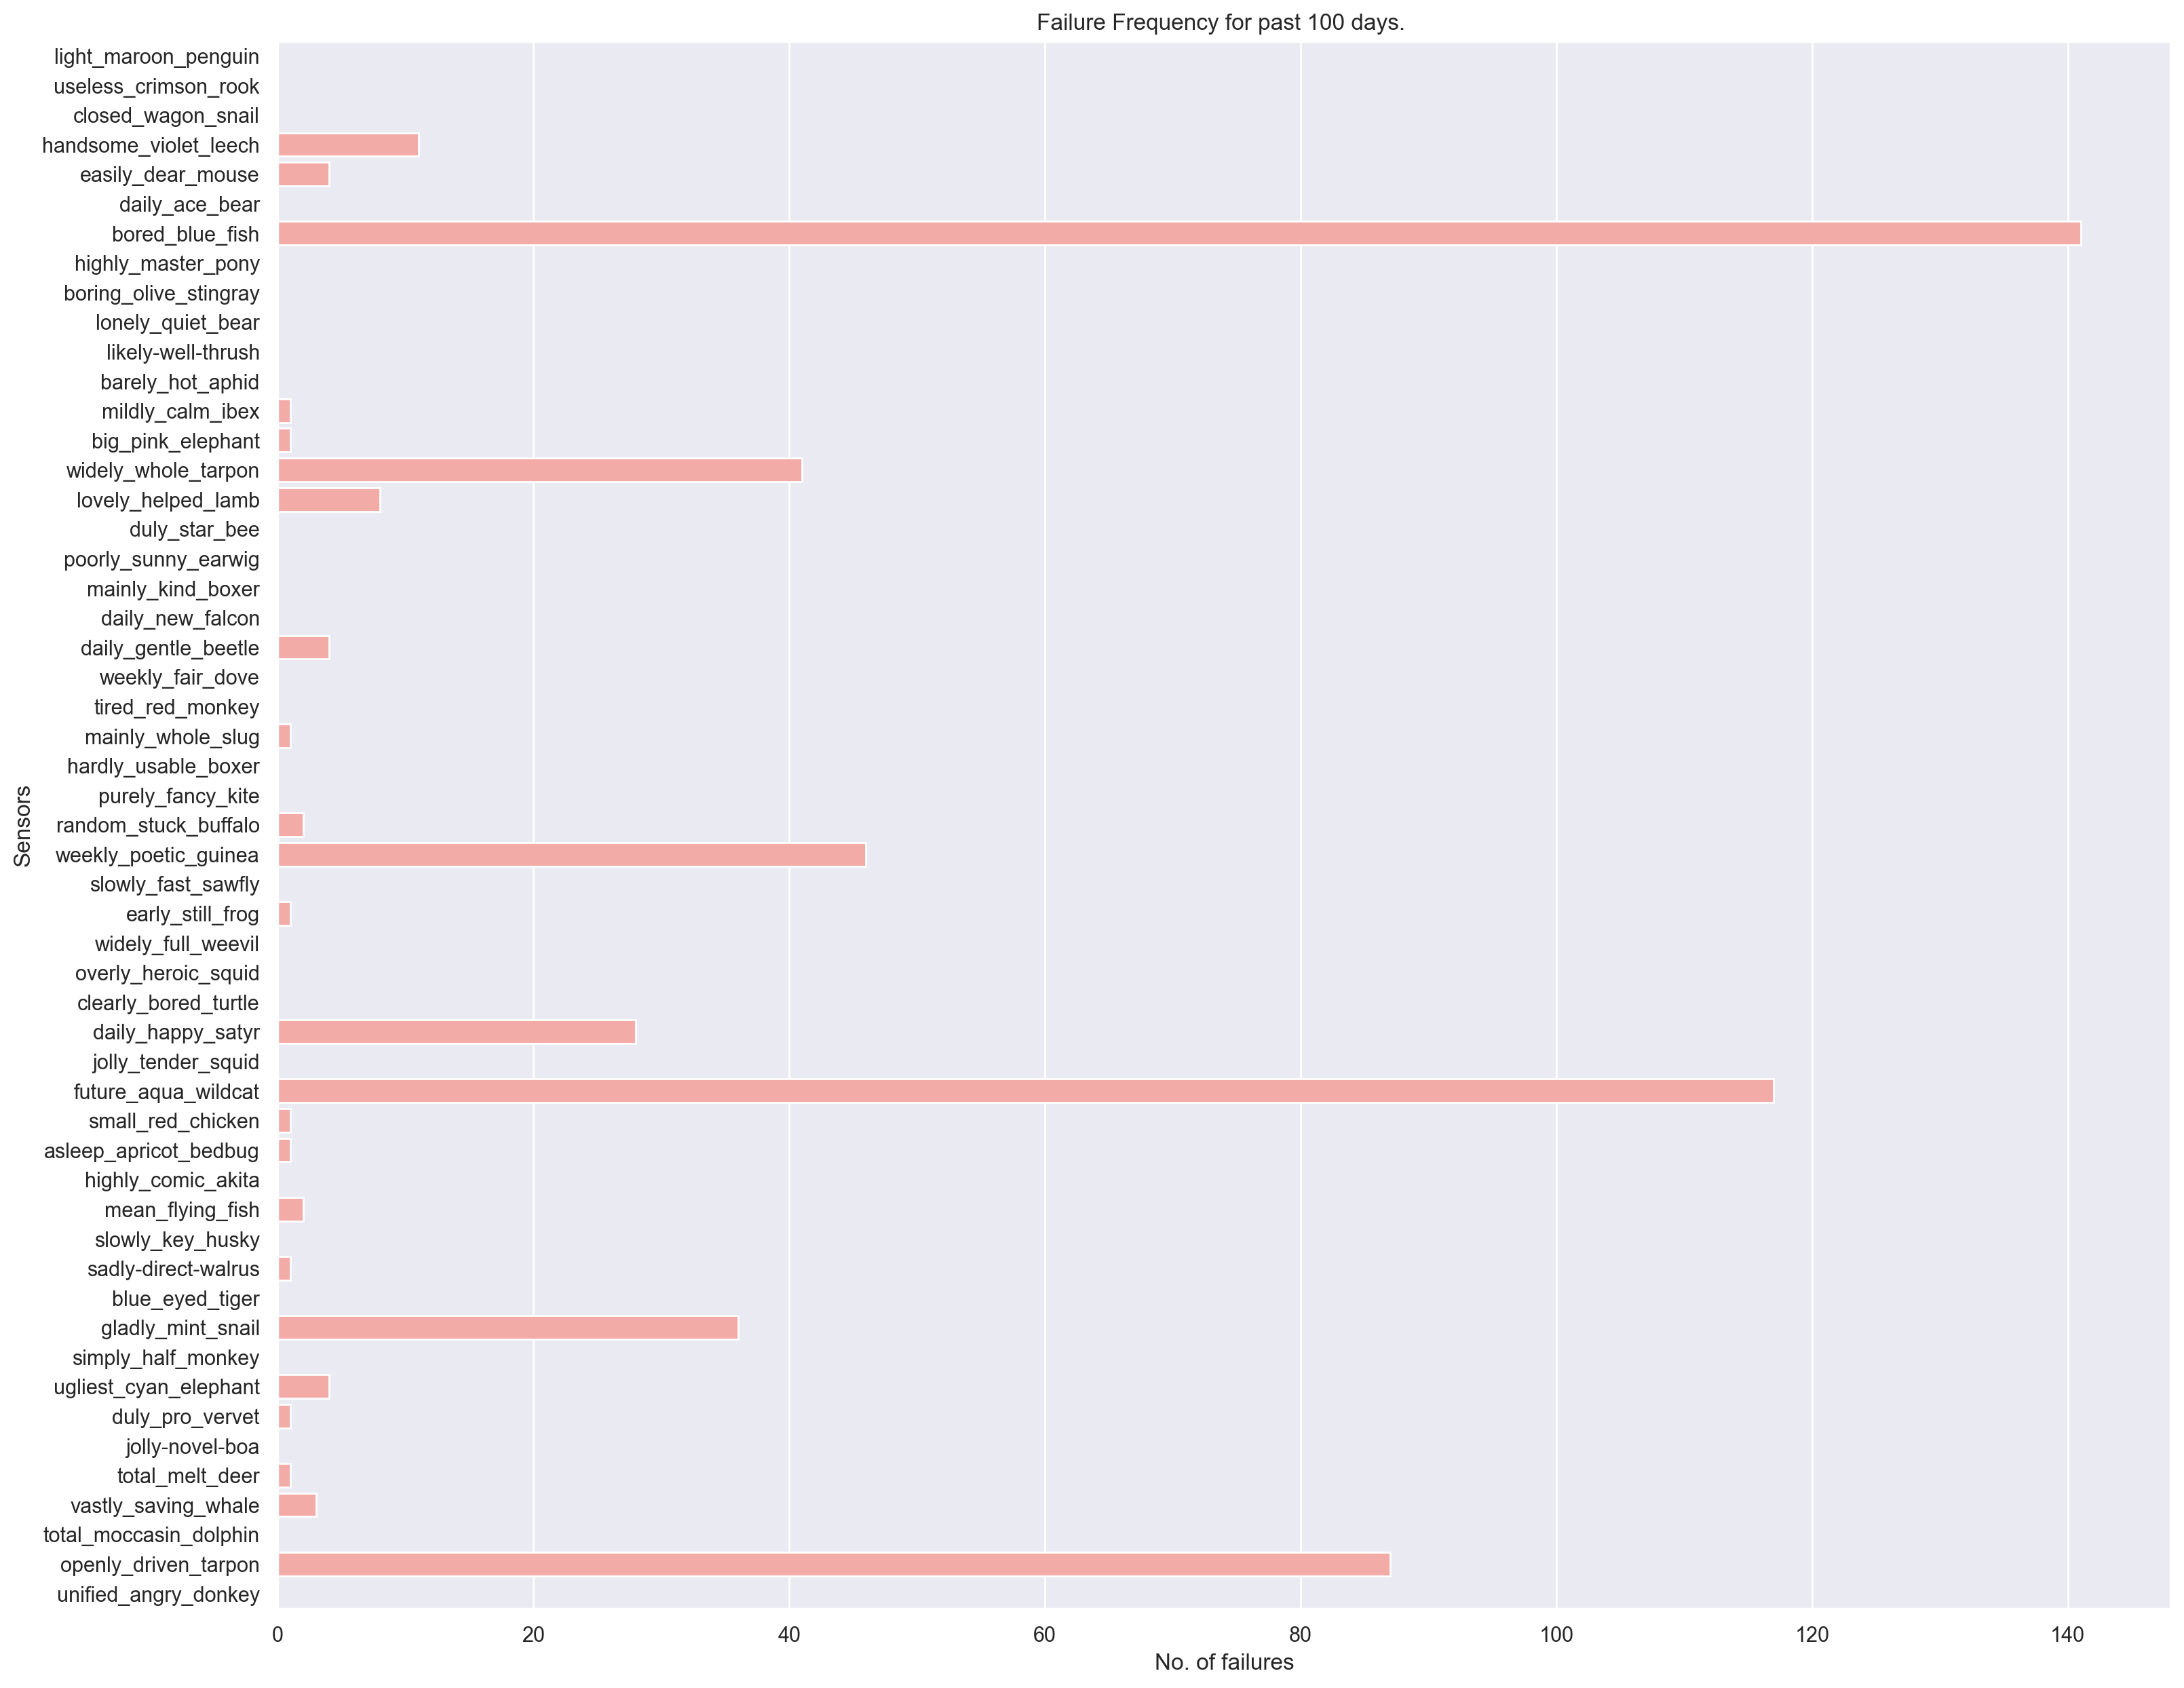

In [67]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(18,15)})
%config InlineBackend.figure_format = 'retina'

# plotting bar graph to see the frequency of failure for individual sensors

labels = list(failing_detail.keys())
heights = list(failing_detail.values())

sns.set_color_codes("pastel")
sns.barplot(x=heights, y=labels,
            label="Total", color="r", orient = 'h')
plt.title('Failure Frequency for past 100 days. ')
plt.ylabel('Sensors')
plt.xlabel('No. of failures')

Text(0.5, 1.0, 'Histogram of Number of failures')

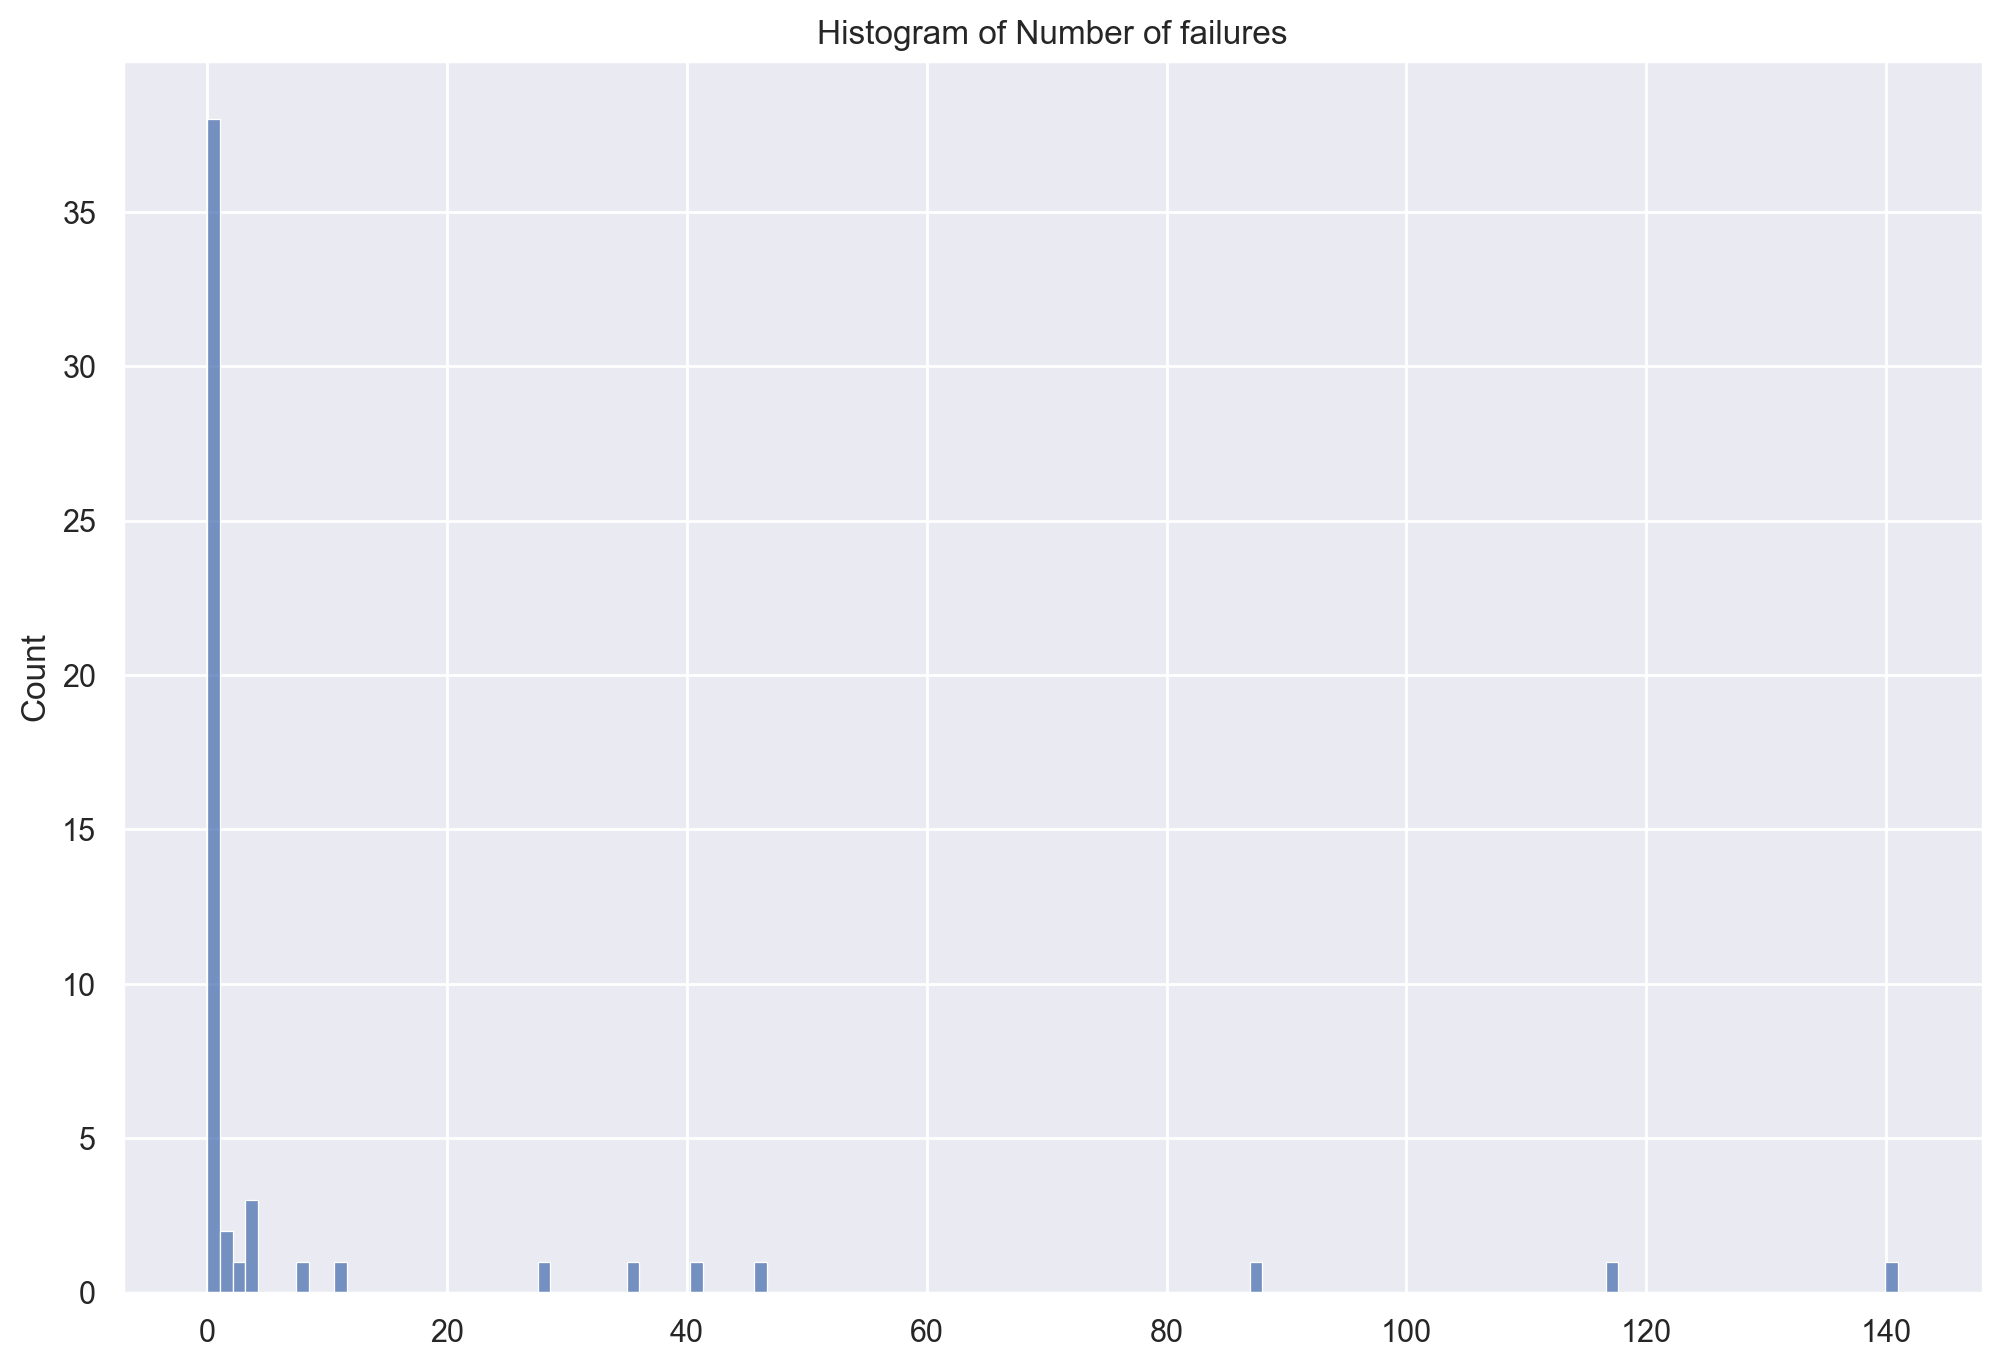

In [69]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.histplot(heights)
plt.title('Histogram of Number of failures')

It seems that most of the sensor failed only a few times but there are quite a few sensors that failed for 20+. times in last 30 days. It would be interesting to see their data and see what could be reason for that failure.

In [10]:
# getting the list of sensors that has failed more more than x times and the indexes associated with that failure

interested_frequency = 20
mostly_failing_data = {}

for key, value in failing_detail.items():
    if value >=interested_frequency:
        mostly_failing_data[key] = missing[key]
        

In [11]:
mostly_failing_data

{'bored_blue_fish': Int64Index([   15,   390,   413,   580,   612,   633,   654,   657,   685,
               694,
             ...
              8452,  8455,  8527,  8559,  8571,  8572,  8578, 10449, 10457,
             10808],
            dtype='int64', length=141),
 'widely_whole_tarpon': Int64Index([1166, 1167, 1230, 1255, 1257, 1281, 1285, 1330, 1449, 1472, 1656,
             1672, 1733, 1803, 1911, 1979, 1982, 2020, 2035, 2145, 2149, 2239,
             2301, 2331, 2357, 2364, 2379, 2408, 2417, 2460, 2467, 2491, 2693,
             2696, 2723, 2813, 2814, 2816, 2829, 2843, 2919],
            dtype='int64'),
 'weekly_poetic_guinea': Int64Index([10080, 19444, 20227, 21003, 21071, 21079, 21161, 21169, 21173,
             21248, 22478, 22746, 22765, 23798, 23805, 23814, 23820, 23824,
             23828, 23836, 23876, 23890, 23896, 24115, 24189, 24198, 24241,
             24249, 24253, 24285, 24352, 24360, 24391, 24392, 24410, 24415,
             24418, 24424, 24435, 24441, 24482, 24494

### Analyzing data for battery voltage

So, I am trying to grab 2 data points before and after the failure of the sensor and see if there is any alarming value in battery voltage. 

ValueError: num must be 1 <= num <= 6, not 7

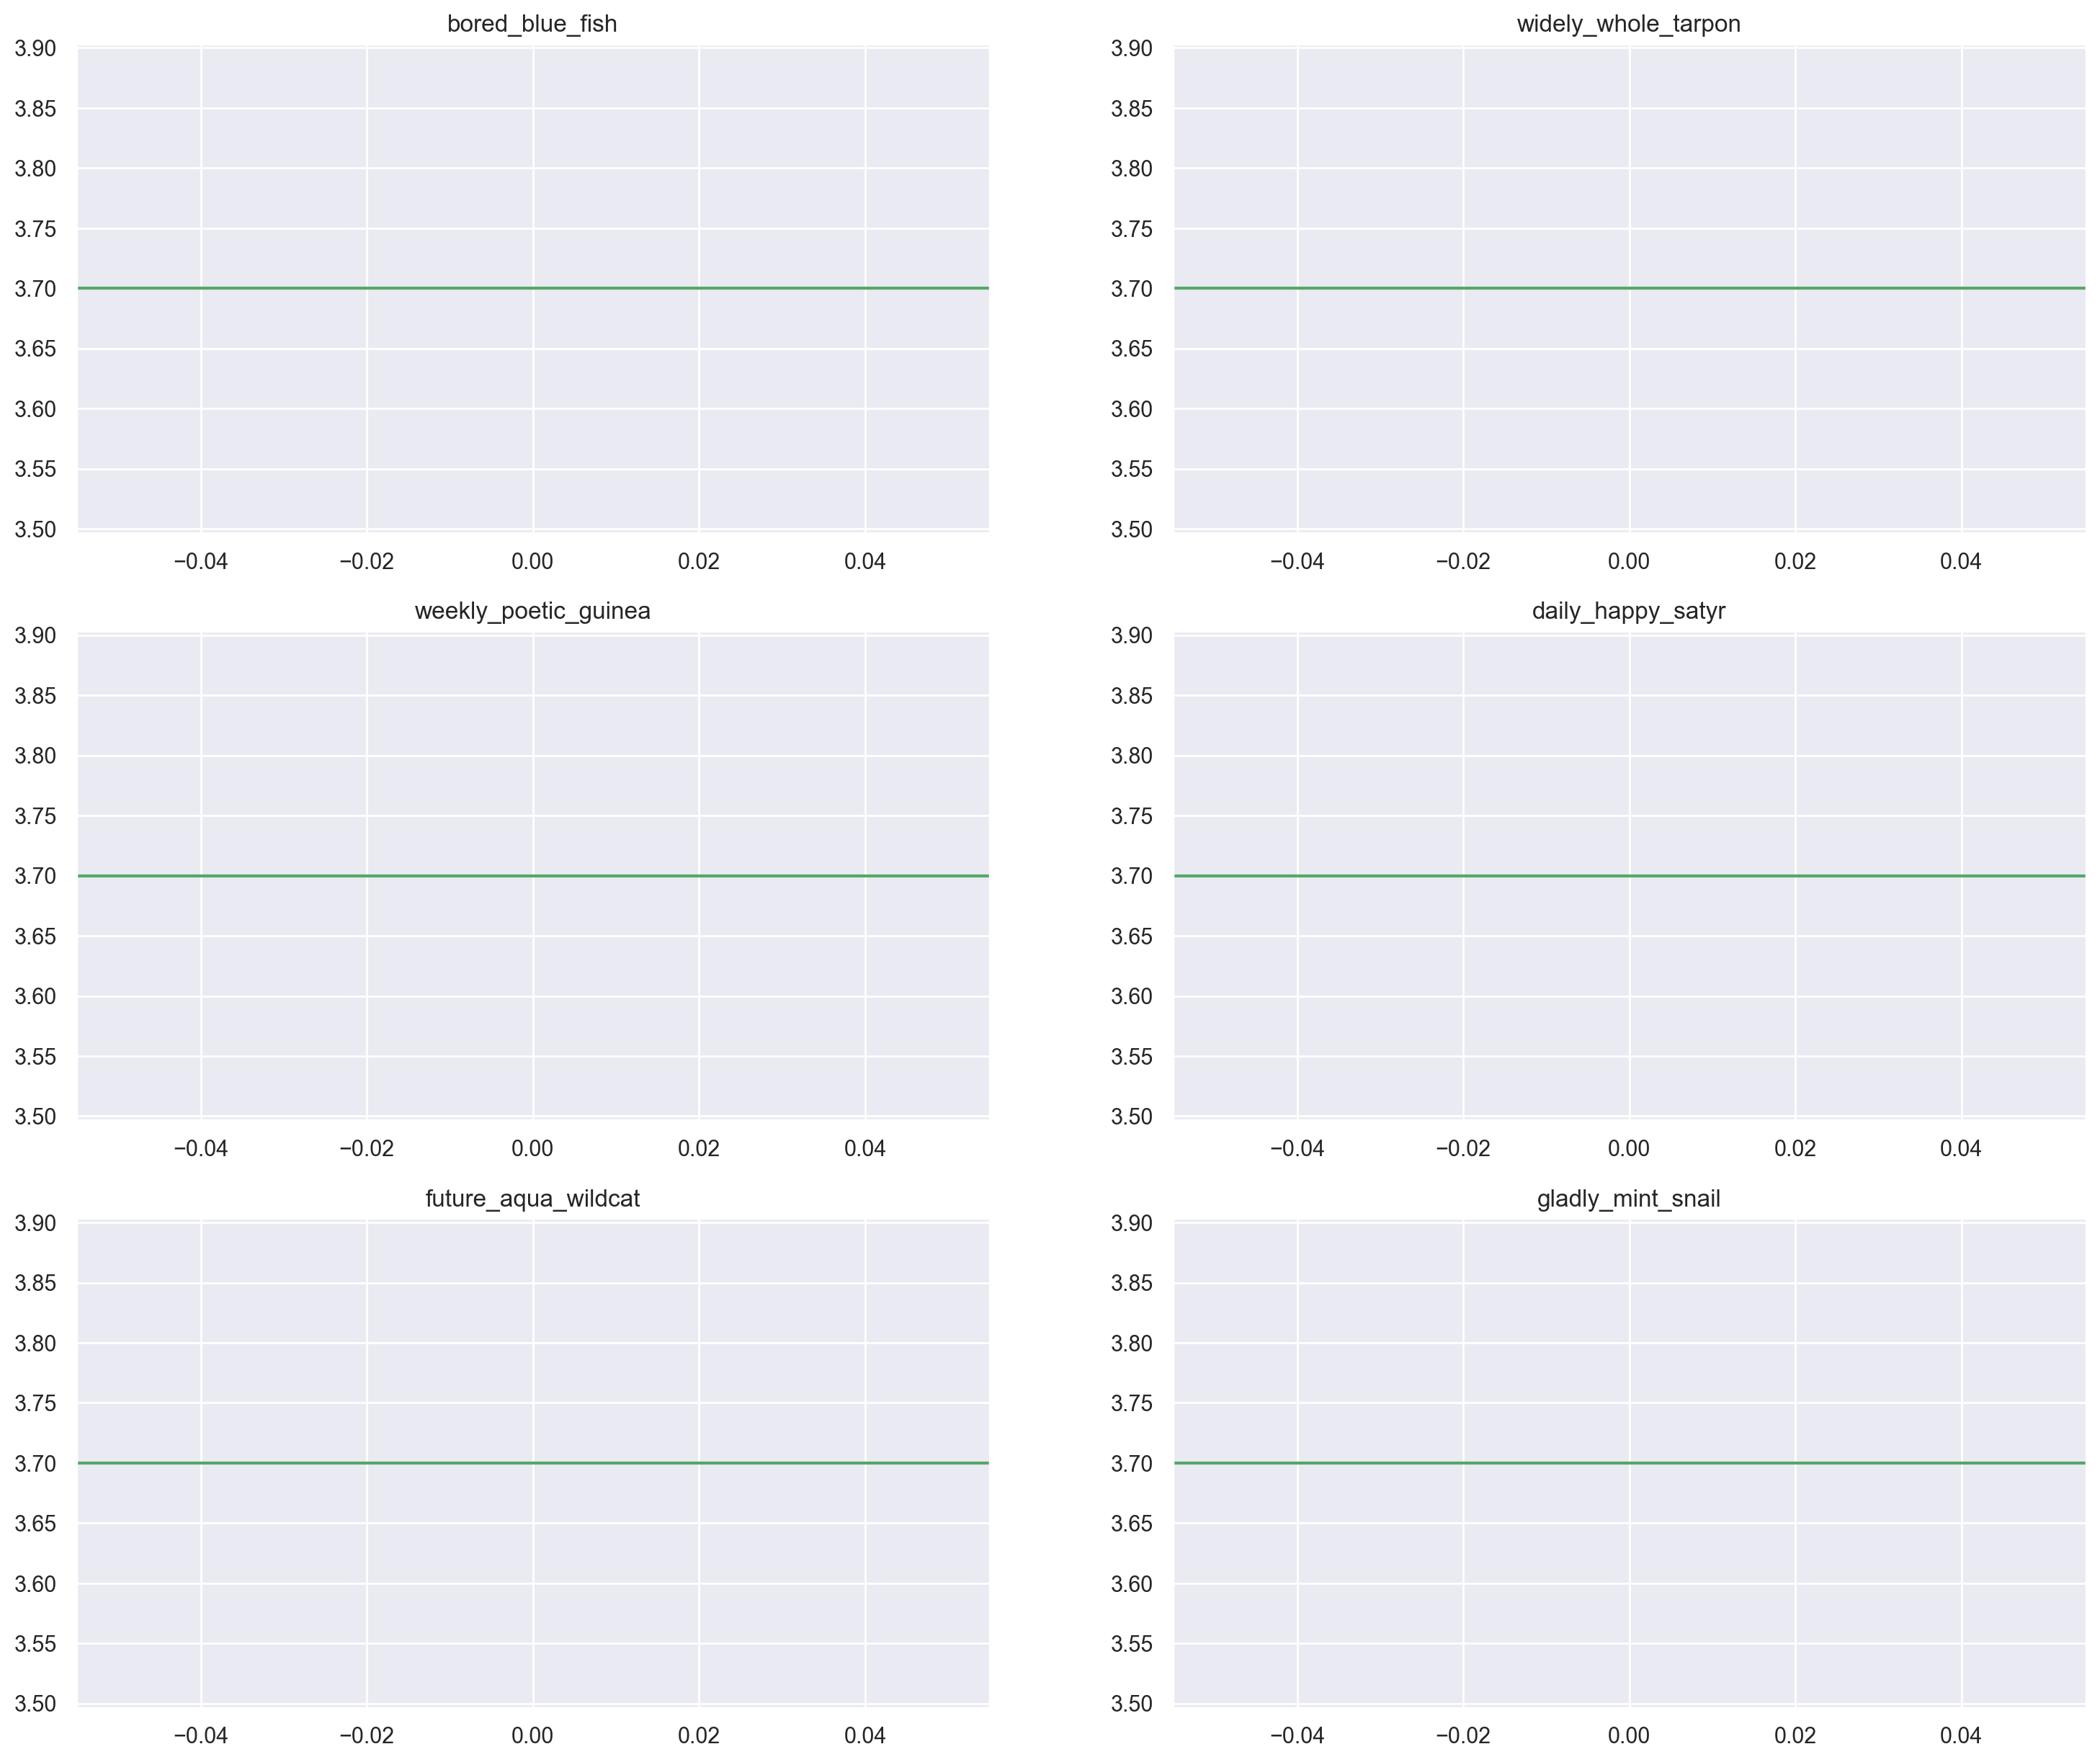

In [20]:
sns.set(rc = {'figure.figsize':(18,15)})
i = 1

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].reindex([interested_index]).sort_values('Unnamed: 0')
    plt.subplot(3,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['batt_v'], color=np.random.rand(3,))
    plt.axhline(y=3.7, color = 'g')
    i += 1
plt.show()

## Observation:
It seems that battery voltage is not the reason of failure for sensors that failed more than 20 times. The reason is something else probably the gateway

### Now looking at other sensors

In [21]:
interested_frequency = 20
less_failing_data = {}

for key, value in failing_detail.items():
    if value > 0 and value < interested_frequency:
        less_failing_data[key] = missing[key]
print(len(less_failing_data))      

17


ValueError: num must be 1 <= num <= 10, not 11

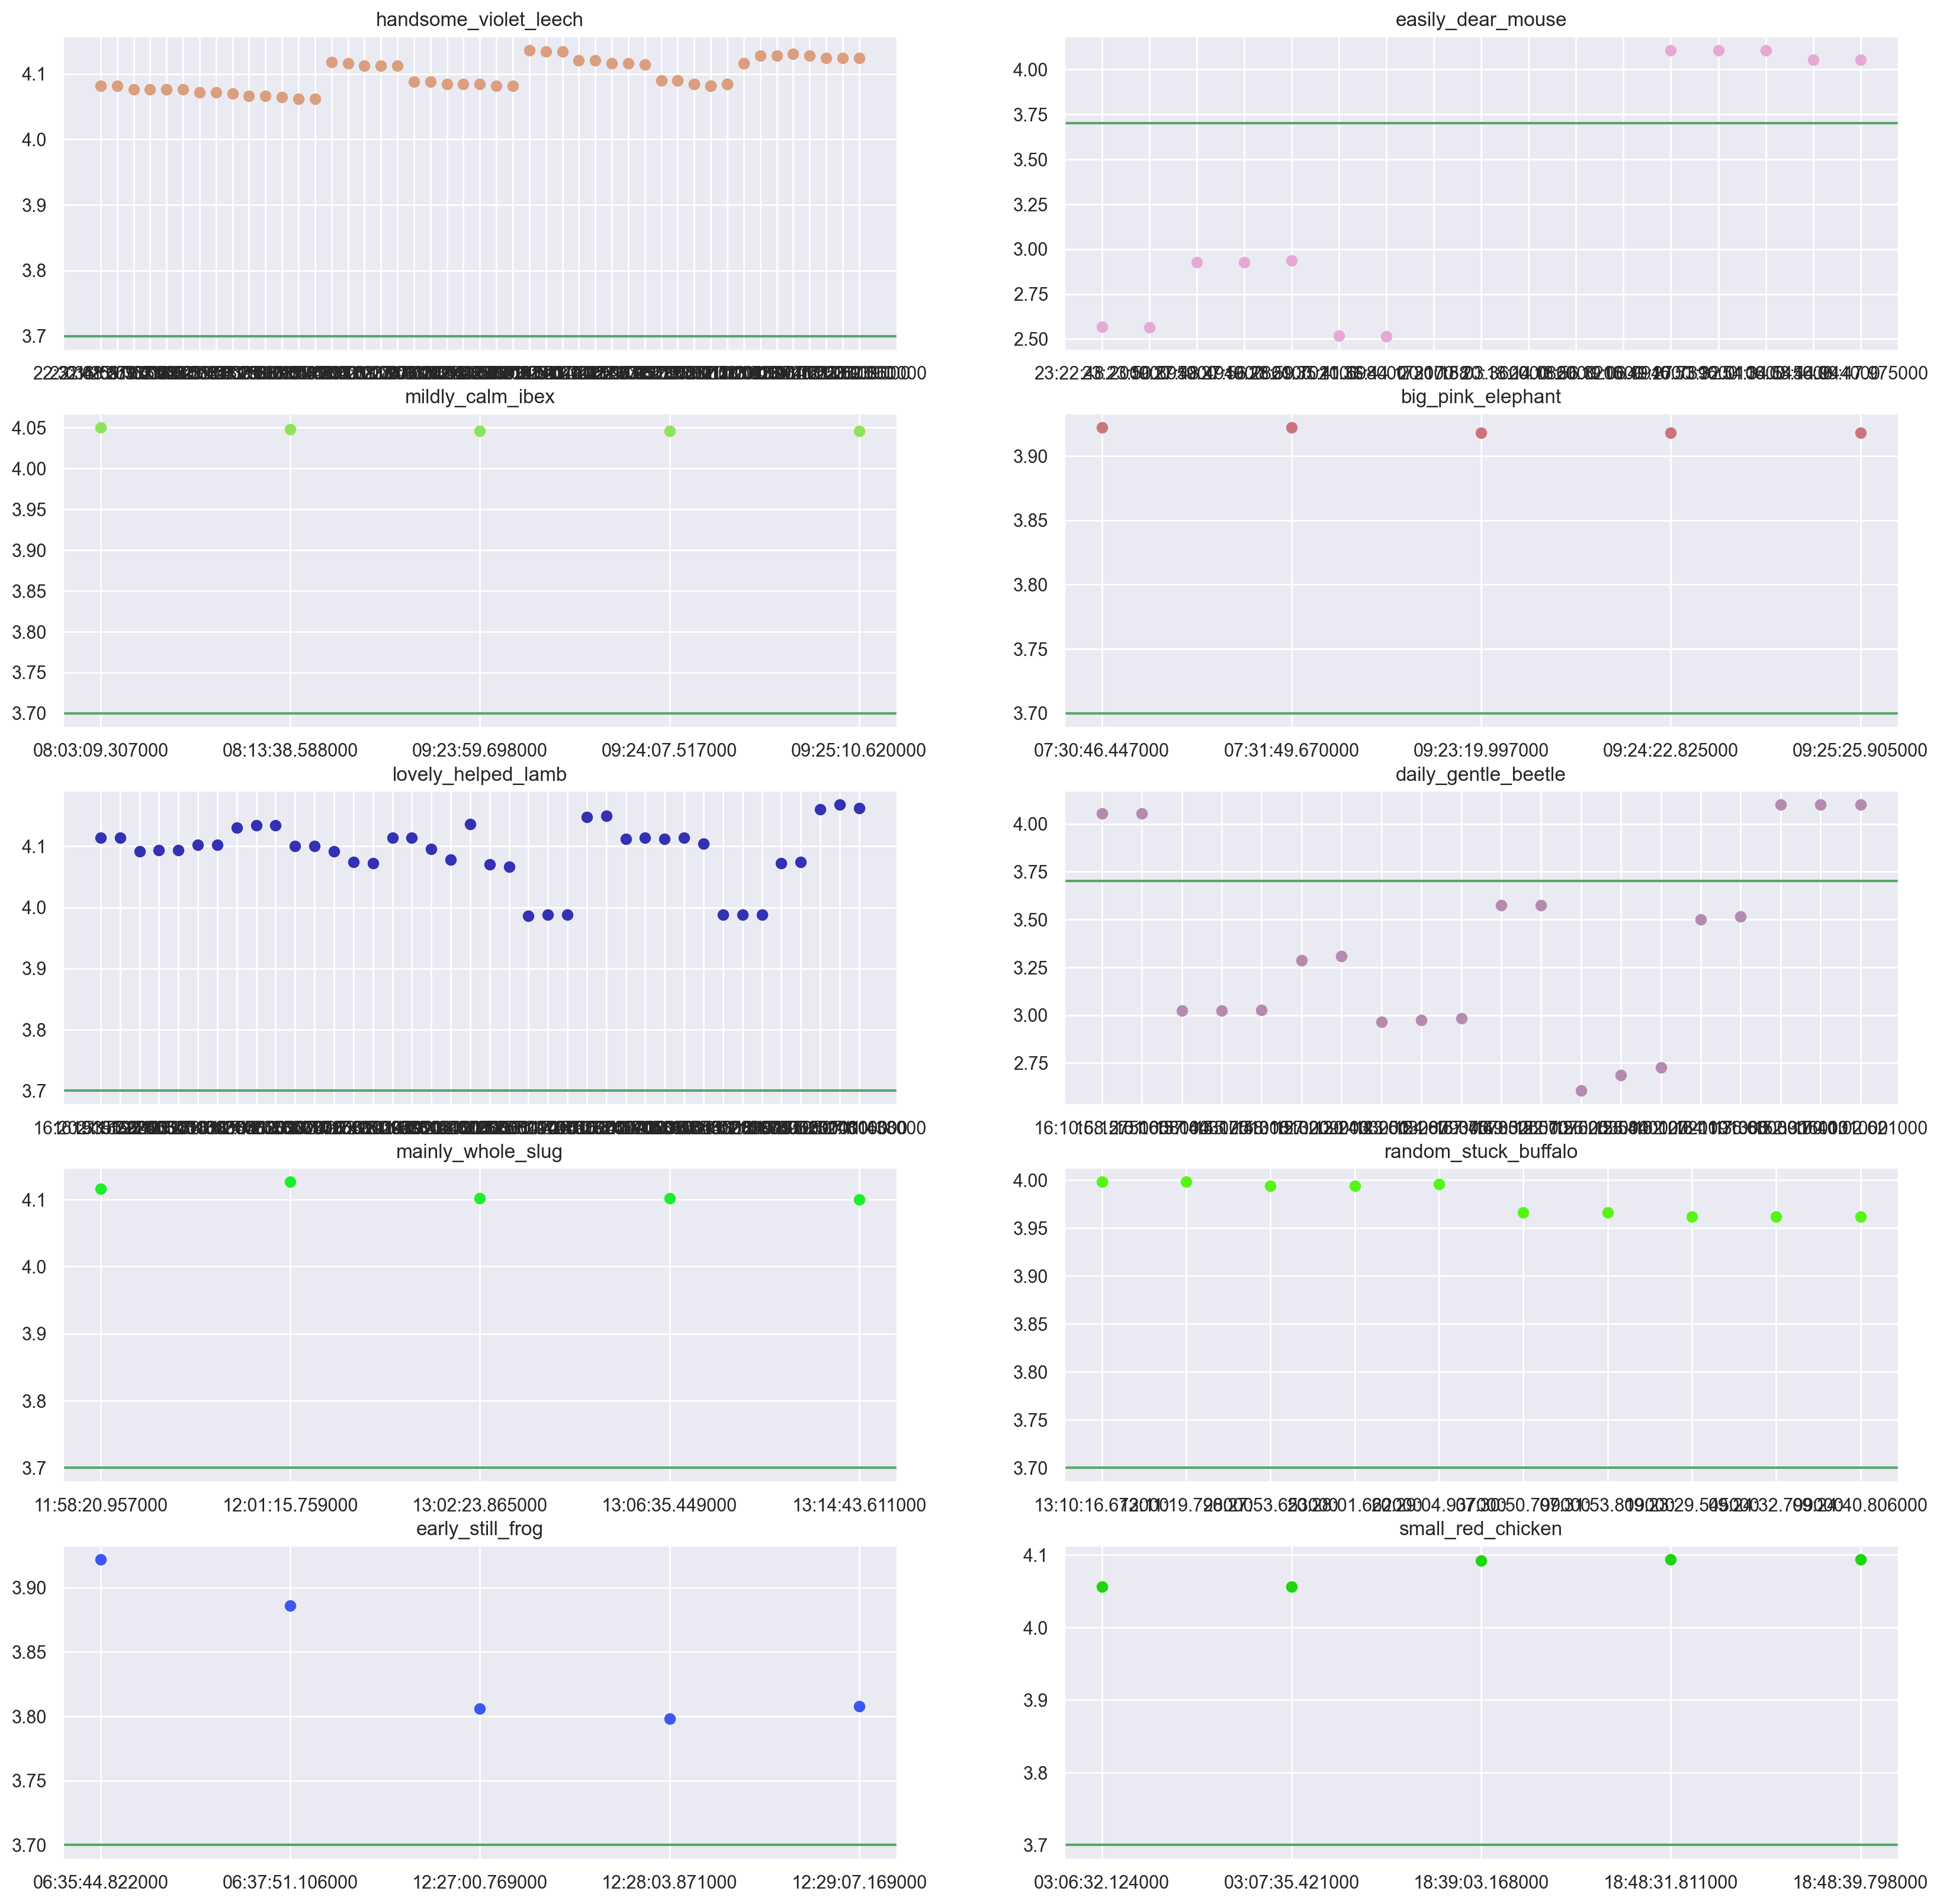

In [22]:
sns.set(rc = {'figure.figsize':(20,20)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(5,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['batt_v'], color=np.random.rand(3,))
    plt.axhline(y=3.7, color = 'g')
    i += 1

## Doing Same analysis for RSSI

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([55389], dtype='int64'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

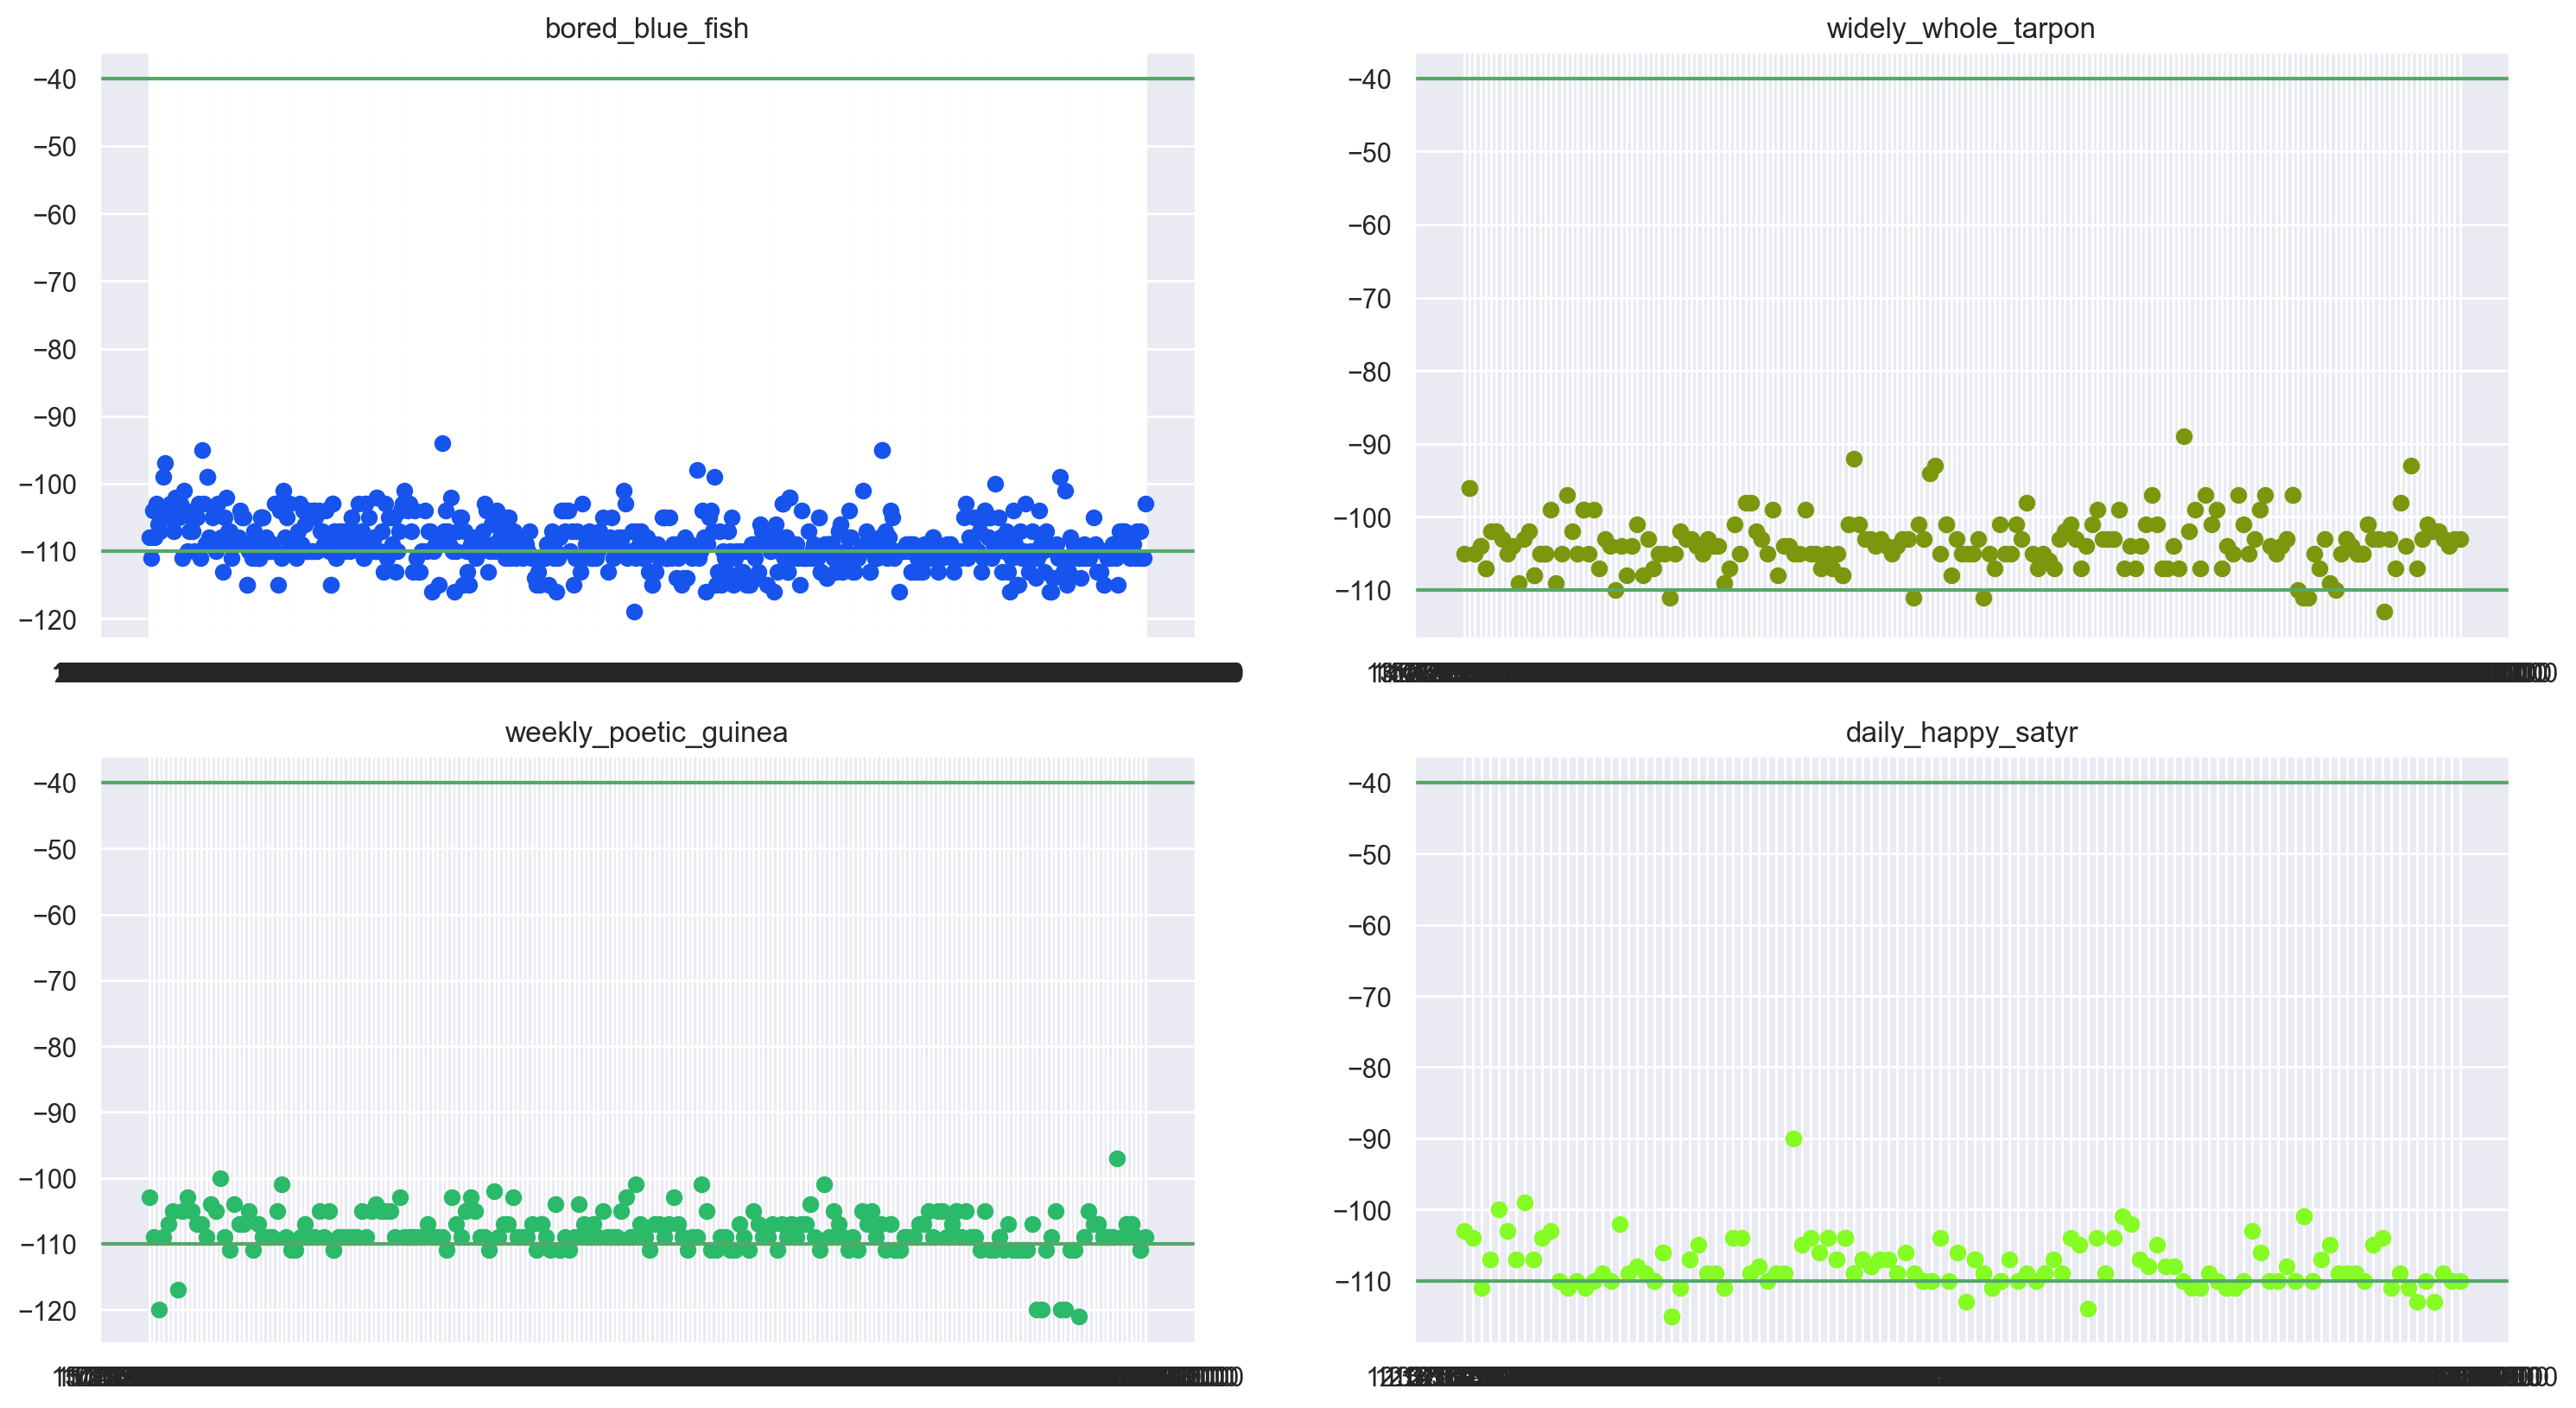

In [15]:
sns.set(rc = {'figure.figsize':(18,15)})
i = 1

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(3,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['gw_1_rssi_dbm'], color=np.random.rand(3,))
    plt.axhline(y=-40, color = 'g')
    plt.axhline(y=-110, color = 'g')
    i += 1
plt.show()

In [ ]:
sns.set(rc = {'figure.figsize':(20,20)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    plt.subplot(5,2, i)
    plt.title(key)
    plt.scatter(x = failing_df['times'], y = failing_df['gw_1_rssi_dbm'], color=np.random.rand(3,))
    plt.axhline(y=-40, color = 'g')
    plt.axhline(y=-110, color = 'g')
    i += 1

In [ ]:
# looking into data for weird daily_gentle_beetle
index = list(less_failing_data['daily_gentle_beetle'])
interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
dfs = dataframes['daily_gentle_beetle']
dfs.loc[interested_index].sort_values('Unnamed: 0')

In [ ]:
index = list(less_failing_data['ugliest_cyan_elephant'])
interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
dfs = dataframes['ugliest_cyan_elephant']
dfs.loc[interested_index].sort_values('Unnamed: 0')

In [ ]:
test_6_13 = pd.DataFrame()

from datetime import date
date1 = date(2023, 6, 13)
date2 = date(2023, 6, 14)
dates = [date1, date2]

for sensor in sensors:
    df = dataframes[sensor]
    add_df = df[(df['gw_1_id'] == 'fngw-10003') & (df['time'].dt.date in dates)]
    test_6_13 = pd.concat([test_6_13, add_df], ignore_index=True)
    #print(f"added {sensor}")
    
test_6_13

In [ ]:
test_6_13[test_6_13['time'].dt.hour == 15]

In [ ]:
test_sensors = list(set(test_6_13['deployment_id']))
test_sensors

In [ ]:
sns.set(rc = {'figure.figsize':(6,6)})
i = 0;
for sensor in test_sensors:
        temp = test_6_13[test_6_13['deployment_id'] == sensor]
        plt.scatter(x = temp['times'], y = [i for _ in range(temp.shape[0])], color=np.random.rand(3,))
        i += 1
        
        

In [ ]:
list(mostly_failing_data.keys()) + list(less_failing_data.keys())

In [ ]:
## plotting battery voltage data for all of the sensors

sns.set(rc = {'figure.figsize':(8,5)})

i = 1
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    #plt.title(key)
    plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)
    plt.axhline(y=3.7, color = 'g')


# for key, values in mostly_failing_data.items():
#     index = list(values)
#     interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) + list(np.asarray(index) + 2)
#     failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
#     #plt.title(key)
#     plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)
#     plt.axhline(y=3.7, color = 'g')


plt.xticks(rotation=45, ha='right')
plt.title('Plot of battery voltage of failing sensors before and after failure')
plt.legend(fontsize='small', loc='lower left')
plt.show()

In [ ]:
pd.to_datetime(failing_df['times'])

In [26]:
failing_df

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
3912,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3919,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6528,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10147,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17621,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17623,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17624,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17628,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.to_datetime(

In [ ]:
less_failing_data

In [ ]:
plt.scatter(x = pd.to_datetime(failing_df['times']), y = failing_df['batt_v'], color=np.random.rand(3,), label=key, s=5)

In [40]:
lis = []
for key, values in less_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) 
    #+ list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    lis.append(failing_df)

for key, values in mostly_failing_data.items():
    index = list(values)
    interested_index = index + list(np.asarray(index) - 1) + list(np.asarray(index) - 2) + list(np.asarray(index) + 1) 
    #+ list(np.asarray(index) + 2)
    failing_df = dataframes[key].loc[interested_index].sort_values('Unnamed: 0')
    lis.append(failing_df)

big_fail = pd.concat(lis)
list({i for i in big_fail['gw_1_id']})

[nan,
 'floodnet-ltap-gw-553232200e001300',
 'fngw-10003',
 'floodnet-ltap-gw-313330372b007400',
 'mikrotik-003300',
 'ttn-nyc-00-08-00-4a-67-fe',
 'floodnet-lr9-gw-3235313229006900',
 'eui-343632383e001c00',
 'irt-mudd-rooftop-gateway',
 'floodnet-ltap-gw-553232201d003500',
 'ttn-nyc-00-08-00-4a-43-21',
 'floodnet-ltap-gw-553232201e001500',
 'fngw-10006',
 'nyc-mocto-1',
 'fngw-10000',
 'kona-mega']

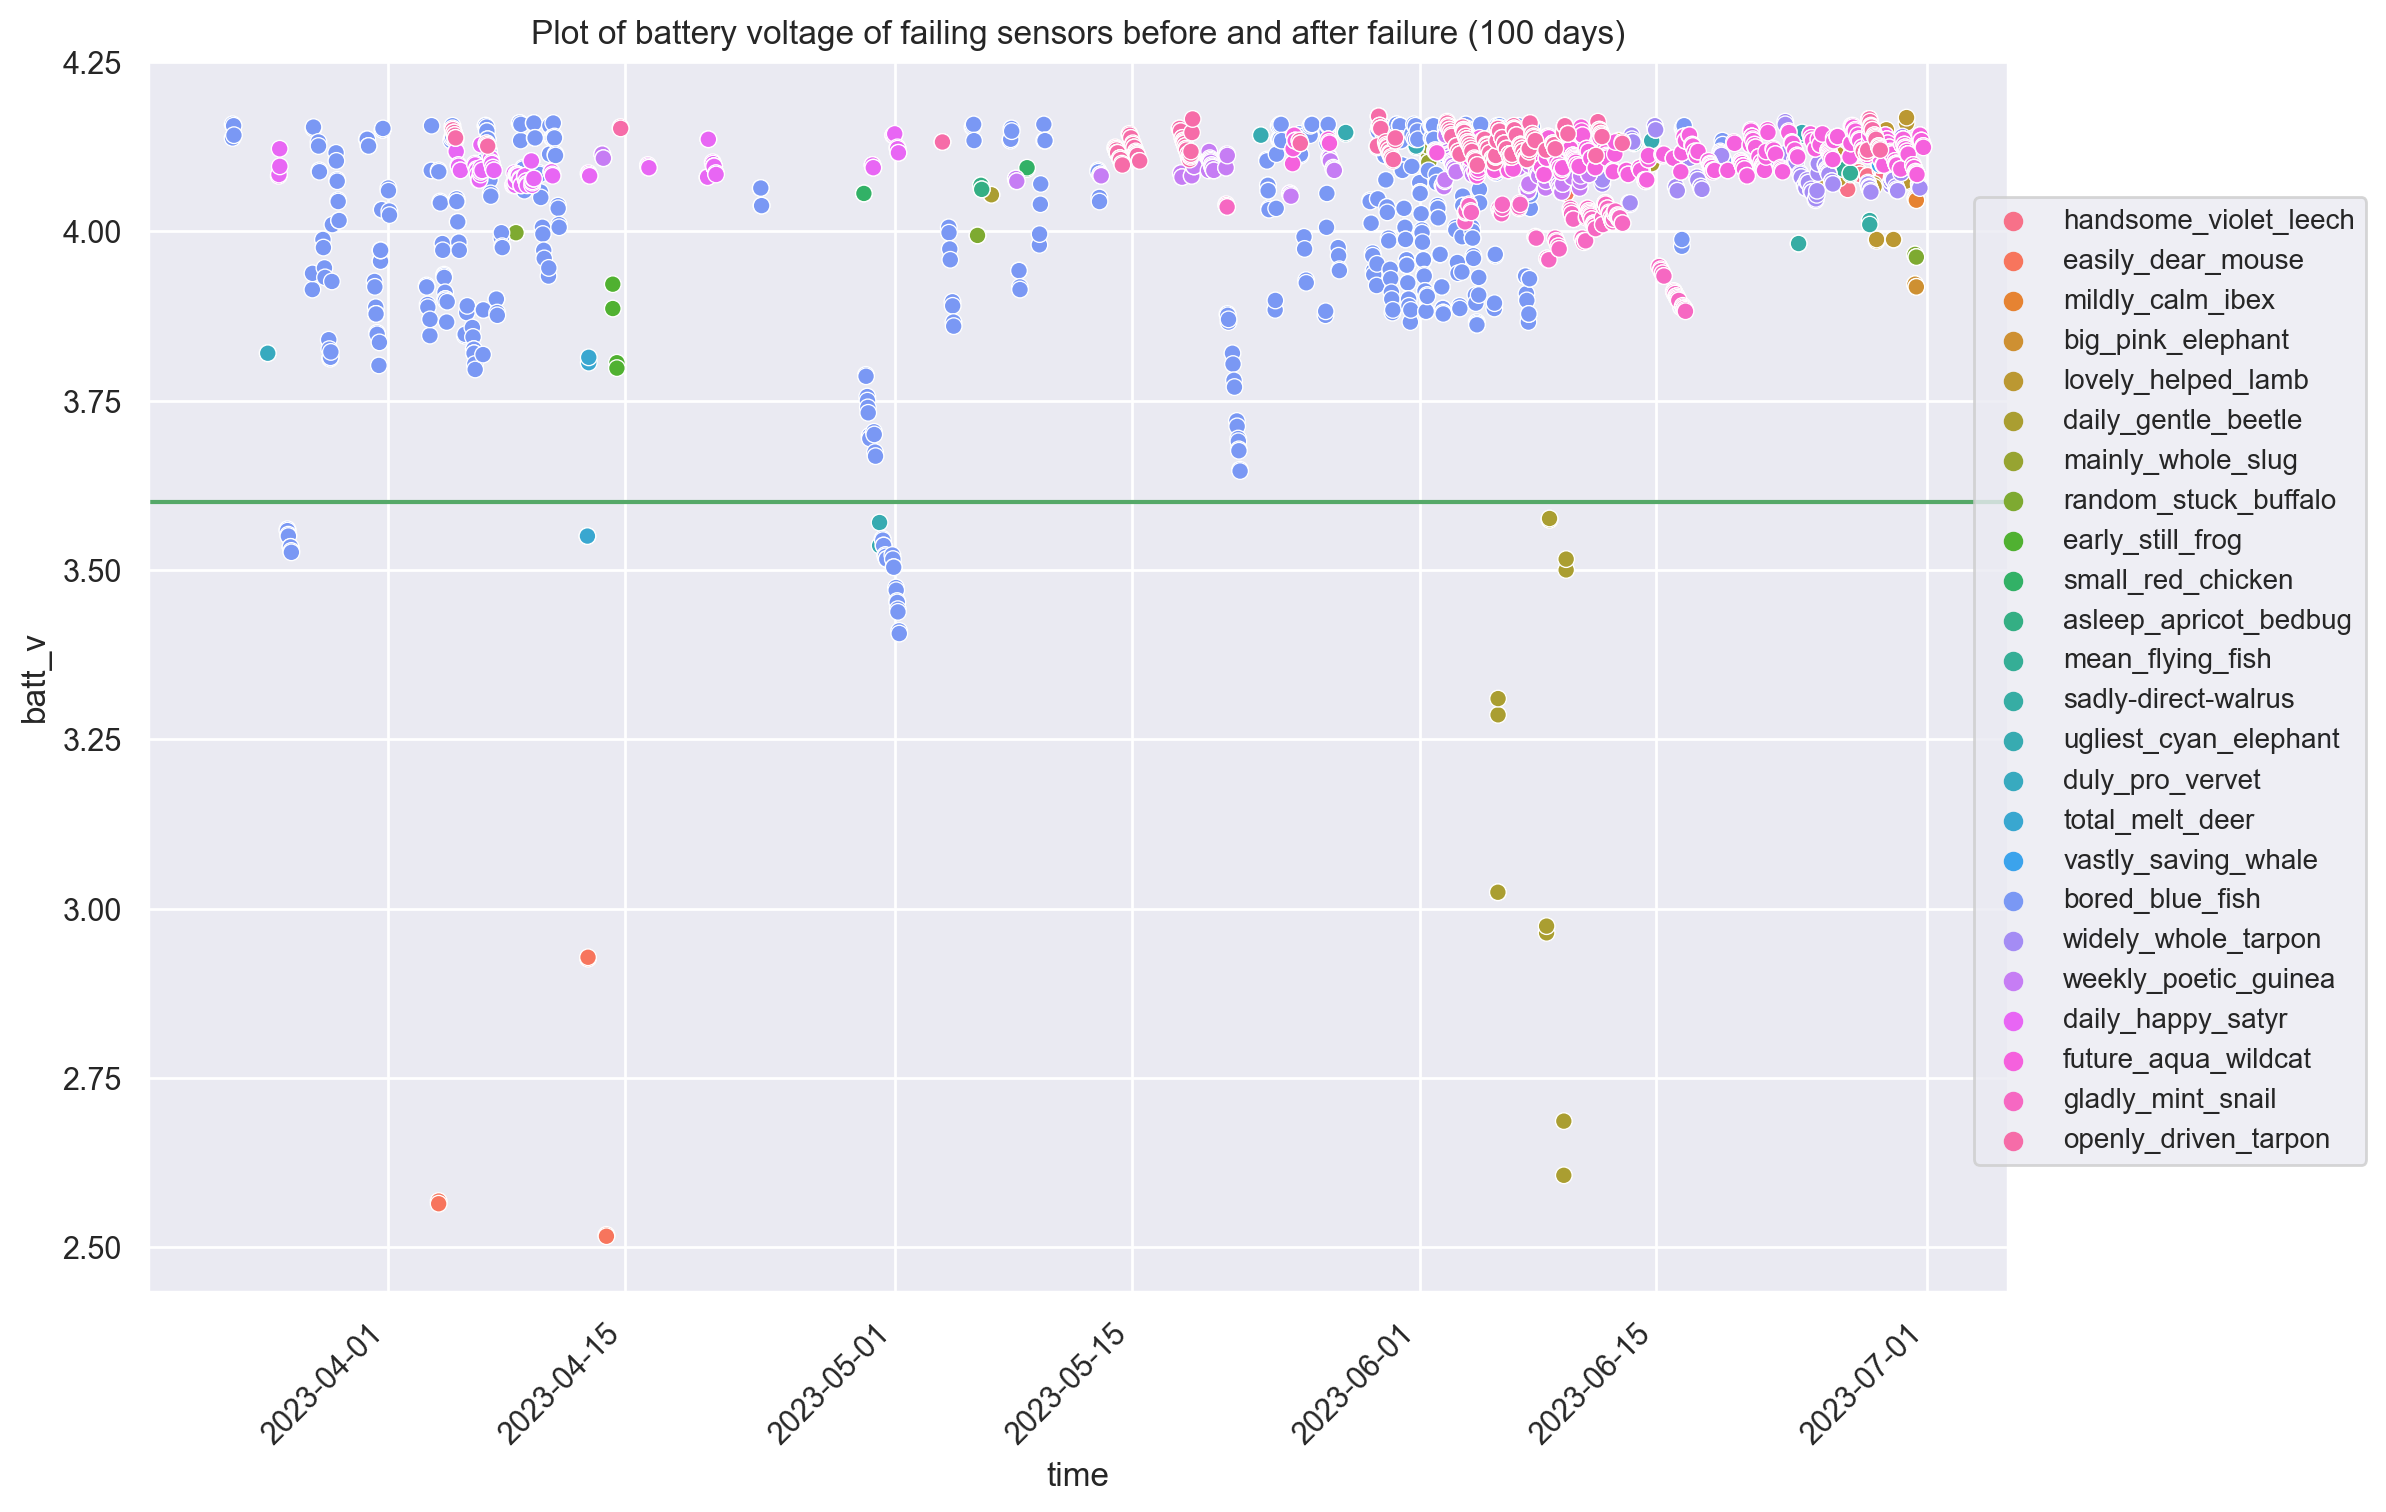

In [58]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.scatterplot(data = big_fail, x = 'time', y = 'batt_v', hue = 'deployment_id')
plt.xticks(rotation=45, ha='right')
plt.title('Plot of battery voltage of failing sensors before and after failure (100 days)')
plt.legend(fontsize='small', loc='upper right',  bbox_to_anchor=(1.2, 0.9))
plt.axhline(y=3.6, color = 'g')
plt.show()

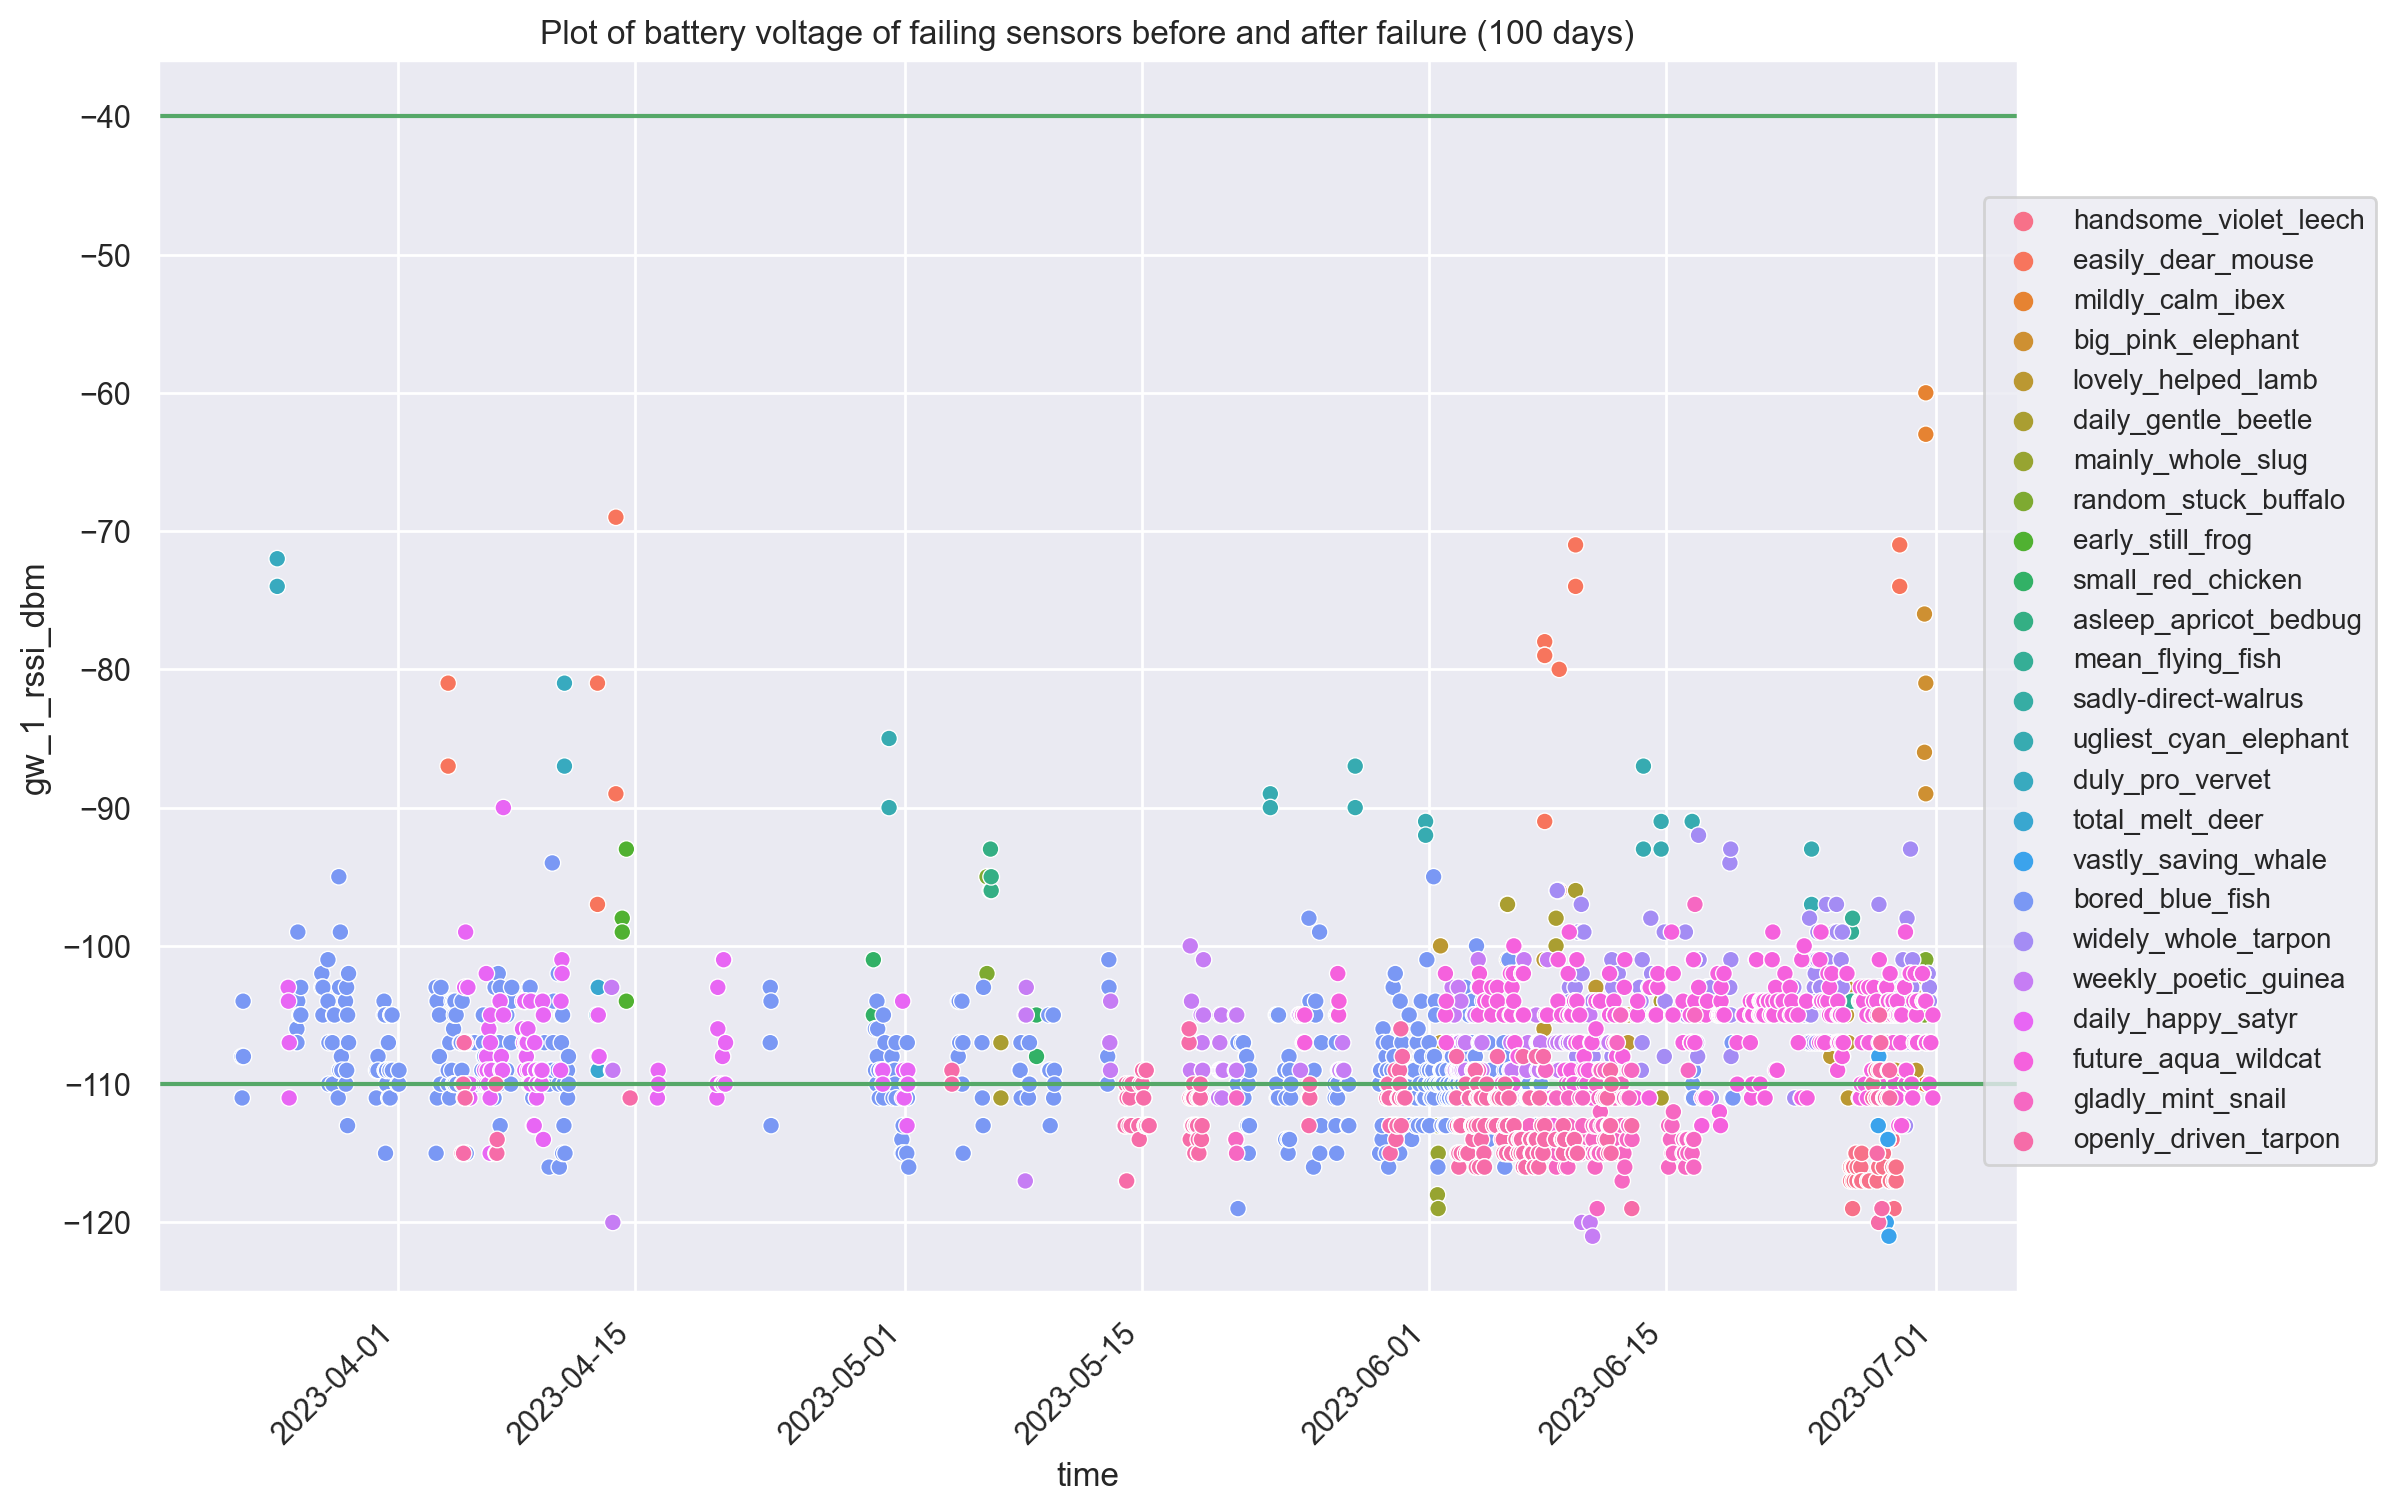

In [55]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.scatterplot(data = big_fail, x = 'time', y = 'gw_1_rssi_dbm', hue = 'deployment_id')
plt.xticks(rotation=45, ha='right')
plt.title('Plot of battery voltage of failing sensors before and after failure (100 days)')
plt.legend(fontsize='small', loc='upper right',  bbox_to_anchor=(1.2, 0.9))
plt.axhline(y=-40, color = 'g')
plt.axhline(y=-110, color = 'g')
plt.show()

In [70]:
big_fail

,Unnamed: 0,time,deployment_id,error_flag,batt_v,gw_1_id,dist_mm,f_cnt,gw_1_rssi_dbm,gw_1_snr_db,times,date
97988,97988,2023-06-25 22:32:48.513000+00:00,handsome_violet_leech,0.0,4.082,floodnet-ltap-gw-553232201e001500,2796.0,138367.0,-117.0,-6.5,22:32:48.513000,2023-06-25
97989,97989,2023-06-25 22:36:59.785000+00:00,handsome_violet_leech,0.0,4.082,floodnet-ltap-gw-553232201e001500,2799.0,138371.0,-116.0,-4.5,22:36:59.785000,2023-06-25
97990,97990,2023-06-26 01:25:59.338000+00:00,handsome_violet_leech,0.0,4.076,floodnet-ltap-gw-553232201e001500,2791.0,138532.0,-119.0,-8.0,01:25:59.338000,2023-06-26
97991,97991,2023-06-26 01:27:02.728000+00:00,handsome_violet_leech,0.0,4.076,floodnet-ltap-gw-553232201e001500,2791.0,138533.0,-116.0,-9.0,01:27:02.728000,2023-06-26
97992,97992,2023-06-26 01:30:11.528000+00:00,handsome_violet_leech,0.0,4.076,floodnet-ltap-gw-553232201e001500,2796.0,138536.0,-116.0,-8.0,01:30:11.528000,2023-06-26
...,...,...,...,...,...,...,...,...,...,...,...,...
17626,17626,2023-06-28 04:04:53.303000+00:00,openly_driven_tarpon,0.0,4.126,kona-mega,2787.0,35223.0,-111.0,-6.2,04:04:53.303000,2023-06-28
17627,17627,2023-06-28 04:33:17.861000+00:00,openly_driven_tarpon,0.0,4.124,kona-mega,2789.0,35251.0,-109.0,-5.5,04:33:17.861000,2023-06-28
17627,17627,2023-06-28 04:33:17.861000+00:00,openly_driven_tarpon,0.0,4.124,kona-mega,2789.0,35251.0,-109.0,-5.5,04:33:17.861000,2023-06-28
17628,17628,2023-06-28 05:58:29.340000+00:00,openly_driven_tarpon,0.0,4.122,kona-mega,2790.0,35333.0,-109.0,-5.2,05:58:29.340000,2023-06-28


In [75]:
c = 0
for i in big_fail['batt_v']:
    if i < 3.6:
        c = c+1
print(c)

50


In [76]:
50/4

12.5

In [80]:
c = 0
for i in big_fail['gw_1_rssi_dbm']:
    if i > -110:
        c = c+1
print(c)

1182


In [81]:
1182/4

295.5